In [1]:
#Use rclone to clone google drive files
#see misc_files/ssh_info.txt
#compare with meterikc in cigale 

#find cigale spectra at: 16 models,  
# /d/vel2/ddale/phangs/synthetic/templates/00_best_model.fits  -  spectrum
# /d/vel2/ddale/phangs/synthetic/templates/models-block-0.fits   - filter flux 


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import re
import sys
from astropy.io import fits
from astropy.visualization import simple_norm, imshow_norm
from ipywidgets import interact, Dropdown
from astropy.wcs import WCS
from astropy.constants import c
from photutils.aperture import CircularAperture, aperture_photometry
import astropy.units as u
from astropy.table import Table
from tabulate import tabulate
from pathlib import Path

parent_dir = Path().resolve().parent #TJ current notebook's parent directory

os.chdir(parent_dir) #TJ change working directory to be the parent directory

from Py_files.Basic_analysis import *


def import_data_and_sort_by_wavelength(file_path):
    '''import data and sort by wavelength
    -------------
    Parameters
    -------------
    file_path : type = str - path to file with data
    
    Returns
    -------------
    structured array ('wavelength', 'intensity', 'uncertainty', 'mask', 'note')
    '''    
    with open(file_path, 'r') as file:
        header = file.readline().strip().split()
        if ((len(header) == 3) & (type(try_float(header[0])) == type(0.1)) & (type(try_float(header[1])) == type(0.1)) & (type(try_float(header[2])) == type(0.1))):
            data_list = []
            data_list.append((try_float(header[0])*1e-6, try_float(header[1])*1e-20, try_float(header[2])*1e-20))
            for line in file:
                parts = line.strip().split(maxsplit=3)
                
                # Convert only numeric columns to floats
                wavelength = float(parts[0])*1e-6 #TJ required for sorting
                intensity = try_float(parts[1])*1e-20
                uncertainty = try_float(parts[2])*1e-20
                
                data_list.append((wavelength, intensity, uncertainty))
        
            # Define dtype with notes as string
            dtype = [
                ('wavelength', float),
                ('intensity', float),
                ('uncertainty', float),
            ]
            
            data = np.array(data_list, dtype=dtype)
            sorted_data = np.sort(data, order=['wavelength'])  # Sort by wavelength
            
            return sorted_data
        elif len(header) == 5:
            data_list = []
            for line in file:
                parts = line.strip().split(maxsplit=4)
                
                # Ensure exactly 5 parts (pad missing values with empty strings)
                parts = parts + [''] * (5 - len(parts))
                
                # Convert only numeric columns to floats
                wavelength = float(parts[0])  # Required for sorting
                intensity = try_float(parts[1])
                uncertainty = try_float(parts[2])
                mask = try_float(parts[3])
                notes = parts[4].strip()  # Keep as string, strip whitespace
                
                data_list.append((wavelength, intensity, uncertainty, mask, notes))
        
        # Define dtype with notes as string
        dtype = [
            ('wavelength', float),
            ('intensity', float),
            ('uncertainty', float),
            ('mask', float),
            ('notes', 'U256')  # Unicode string (max length 256)
        ]
        
        data = np.array(data_list, dtype=dtype)
        sorted_data = np.sort(data, order=['wavelength'])  # Sort by wavelength
        
        return sorted_data

# Step 1: Extract filter names (e.g., "f164n" from .fits, "F070M" from .dat)
def extract_filter_name(filename):
    # For .fits files: ngc5194_nircam_1v3_f164n_i2d.fits → "f164n"
    if filename.endswith('.fits'):
        parts = os.path.basename(filename).split('_')
        for part in parts:
            if part.startswith('f') and part[1:].replace('n', '').replace('w', '').replace('m', '').isdigit():
                return part.lower()
    # For .dat files: F070M.dat → "f070m"
    elif filename.endswith('.dat'):
        return os.path.splitext(os.path.basename(filename))[0].lower()
    return None


def generate_list_of_files():
        
    filter_directory = '/d/crow1/tools/cigale/database_builder/filters/jwst/'
    path = ['nircam', 'miri']
    filter_files = np.concatenate([glob.glob(os.path.join(filter_directory + file_path, "*.dat")) for file_path in path])
    image_directory = 'Data_files/Image_files'
    image_files = glob.glob(os.path.join(image_directory, "*.fits"))
    # Initialize aligned lists
    image_file_array = []
    filter_file_array = []
    
    # Loop through .fits files and find matching .dat files
    for fits_file in image_files:
        fits_filter = extract_filter_name(fits_file)
        if not fits_filter:
            continue  # Skip if no filter name found
        
        # Search for matching .dat file
        for dat_file in filter_files:
            dat_filter = extract_filter_name(dat_file)
            if dat_filter == fits_filter:
                image_file_array.append(fits_file)
                filter_file_array.append(dat_file)
                break  # Stop searching after first match
    return image_file_array, filter_file_array



def get_Fnu_transmission(Fnu_array, wl_array, transmission_array, trans_wl_array):
    '''get expected flux through filter in units of whatever the flux_array is. Make sure to convert to mks units
    -------------
    Parameters
    -------------
    Fnu_array : type = array - array of flux density values
    wl_array : type = array - array of wavelength values for the corresponding Fnu_array values
    transmission_array : type = array - array of unitless transmission coefficient
    trans_wl_array : type = array - array of wavelength values for the corresponding transmission values


    
    Returns
    -------------
    total_flux : type = float - in units of flux_array
    '''   
    Fnu_array = np.array(Fnu_array)
    wl_array = np.array(wl_array)
    transmission_array = np.array(transmission_array)
    trans_wl_array = np.array(trans_wl_array)
    # Convert wavelength to frequency, reverse so freq increases left to right
    spec_freq_array = c / wl_array[::-1]
    Fnu_array = Fnu_array[::-1]
    
    trans_freq_array = c / trans_wl_array[::-1]
    transmission_array = transmission_array[::-1]
    
    # Interpolate Fnu onto the transmission frequency grid
    interp_Fnu = np.interp(trans_freq_array, spec_freq_array, Fnu_array)
    weight = transmission_array / trans_freq_array
    numerator = np.trapz(interp_Fnu * weight, trans_freq_array)
    denominator = np.trapz(weight, trans_freq_array)
    ab_mean_flux = numerator / denominator
    # Numerator: Fν * Transmission integrated over frequency
    
    return ab_mean_flux


def get_Flambda_transmission(Fnu_array, wl_array, transmission_array, trans_wl_array):
    '''get expected flux through filter in units of whatever the flux_array is. Make sure to convert to mks units
    -------------
    Parameters
    -------------
    flux_array : type = array - array of flux values
    spec_wl_array : type = array - array of wavelength values for the corresponding flux_array values
    transmission_array : type = array - array of unitless transmission coefficient
    transmission_wl_array : type = array - array of wavelength values for the corresponding transmission values


    
    Returns
    -------------
    total_flux : type = float - in units of flux_array
    '''   
    first_wl = trans_wl_array[0]
    last_wl = trans_wl_array[-1]
    relevent_SED_wl = wl_array[((wl_array > first_wl) & (wl_array < last_wl))]
    relevent_SED_flux = Fnu_array[((wl_array > first_wl) & (wl_array < last_wl))]
    T_interp = np.interp(relevent_SED_wl, trans_wl_array, transmission_array)
    F_T = relevent_SED_flux * T_interp
    numerator = np.trapz(F_T, relevent_SED_wl)
    denominator = np.trapz(transmission_array, trans_wl_array)
    return numerator/denominator


Current Working Directory: /d/ret1/Taylor/jupyter_notebooks/Research


In [6]:
image_files, filter_files = generate_list_of_files()

filter_files

['/d/crow1/tools/cigale/database_builder/filters/jwst/nircam/F164N.dat',
 '/d/crow1/tools/cigale/database_builder/filters/jwst/nircam/F115W.dat',
 '/d/crow1/tools/cigale/database_builder/filters/jwst/nircam/F140M.dat',
 '/d/crow1/tools/cigale/database_builder/filters/jwst/nircam/F150W.dat',
 '/d/crow1/tools/cigale/database_builder/filters/jwst/nircam/F182M.dat',
 '/d/crow1/tools/cigale/database_builder/filters/jwst/nircam/F210M.dat',
 '/d/crow1/tools/cigale/database_builder/filters/jwst/nircam/F250M.dat',
 '/d/crow1/tools/cigale/database_builder/filters/jwst/nircam/F200W.dat',
 '/d/crow1/tools/cigale/database_builder/filters/jwst/nircam/F212N.dat',
 '/d/crow1/tools/cigale/database_builder/filters/jwst/nircam/F187N.dat',
 '/d/crow1/tools/cigale/database_builder/filters/jwst/nircam/F360M.dat',
 '/d/crow1/tools/cigale/database_builder/filters/jwst/nircam/F335M.dat',
 '/d/crow1/tools/cigale/database_builder/filters/jwst/nircam/F300M.dat',
 '/d/crow1/tools/cigale/database_builder/filters/jw

In [7]:
image_files, filter_files = generate_list_of_files()
SED_filepath = 'Data_files/ARM2_HII2_conv_stitched_test.dat' #TJ switch to this one and rerun to get the convolved array
#SED_filepath = 'Data_files/ARM2_HII2_stitch.dat'
SED_data = import_data_and_sort_by_wavelength(SED_filepath)
#SED_data = convert_sed_to_frequency(SED_data["wavelength"], SED_data["intensity"], SED_data["uncertainty"])
IFU_filepath = 'Data_files/IFU_files/M51_SW_f290lp_g395m-f290lp_s3d.fits'
hdul = fits.open(IFU_filepath)
IFU_data = hdul['SCI'].data  # flux in MJy/sr or μJy/arcsec²
IFU_header = hdul['SCI'].header
filter_data_array = []
radius = 0.75*u.arcsecond
aperture_area_sr = np.pi * (radius.to(u.rad))**2
for file in filter_files:
    data = []
    with open(file, 'r') as f:
            header = f.readline().strip().split()
            for line in f:
                data_line = line.strip().split()
                data.append(data_line)
            
    header, filter_T = data[:2], np.array(data[2:])
    wl = [try_float(filter_T[i,0])*1e-10 for i in range(len(filter_T))]
    T = [try_float(filter_T[i,1]) for i in range(len(filter_T))]
    #hz, T = convert_transmission_to_frequency(wl, T)
    filter_data_array.append([wl, T])




expected_flux_array = []

for i, filter_data in enumerate(filter_data_array):
    expected_flux_array.append((get_Fnu_transmission(SED_data["intensity"], SED_data["wavelength"], filter_data[1], filter_data[0])*aperture_area_sr).value)

    show_SED = False
    show_filter = False
    show_filter_pass = False
'''
    if show_filter:
        plt.plot(filter_data[0], filter_data[1], color = 'blue')
        plt.xlabel('wavelength (m)')
        plt.ylabel('T (%)')
        plt.title('filter transmission')
        plt.show()
    if show_SED:
        plt.plot(relevent_SED_wl, relevent_SED_flux, color = 'red')
        plt.xlabel('wavelength (m)')
        plt.ylabel('F*nu')
        plt.title('SED flux')
        plt.show()

    if show_filter_pass:
        plt.plot(relevent_SED_wl, F_T, color = 'purple')
        plt.xlabel('wavelength (m)')
        plt.ylabel('F*T*nu')
        plt.title(f'{filter_files[i].split("/")[-1]}')
        plt.show()
'''
print()


202.47083333333333 47.195277777777775 0
Total flux in aperture 3: 3.8744695973243885e-30
expected 3.3857200768582966e-30, ratio : 0.873853824842603


Set DATE-AVG to '2024-05-31T13:46:47.255' from MJD-AVG.
Set DATE-END to '2024-05-31T13:51:53.300' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -33.081922 from OBSGEO-[XYZ].
Set OBSGEO-H to 1708040882.602 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


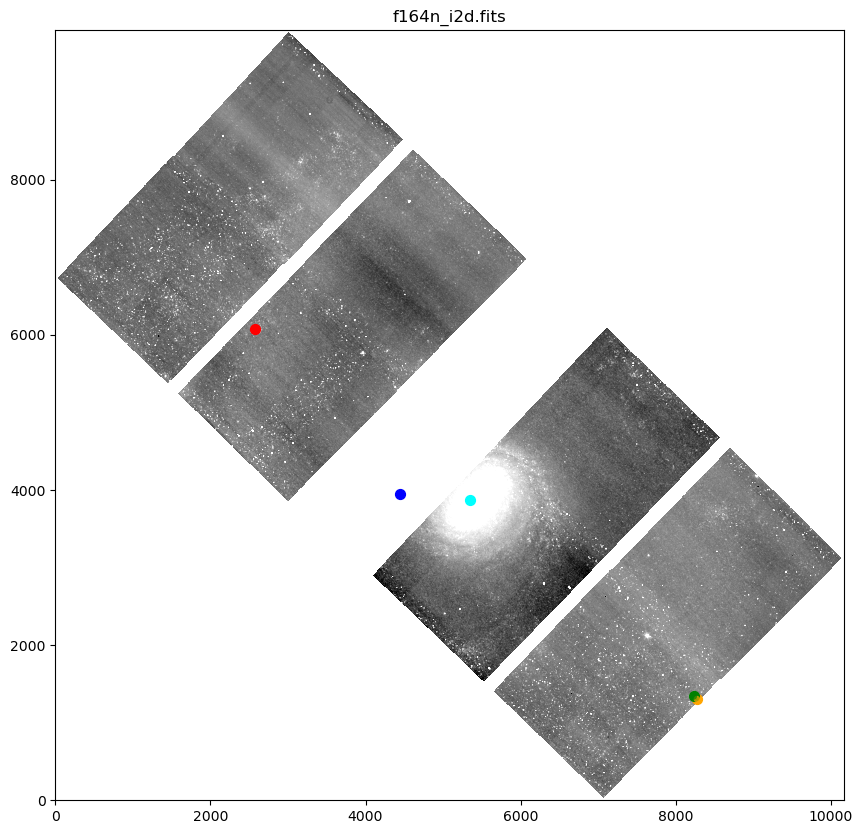

Set DATE-AVG to '2023-06-14T18:26:43.496' from MJD-AVG.
Set DATE-END to '2023-06-14T19:02:31.534' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -35.938385 from OBSGEO-[XYZ].
Set OBSGEO-H to 1721146417.406 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Total flux in aperture 3: 3.212866135897431e-30
expected 3.0190052970592177e-30, ratio : 0.9396610905533221


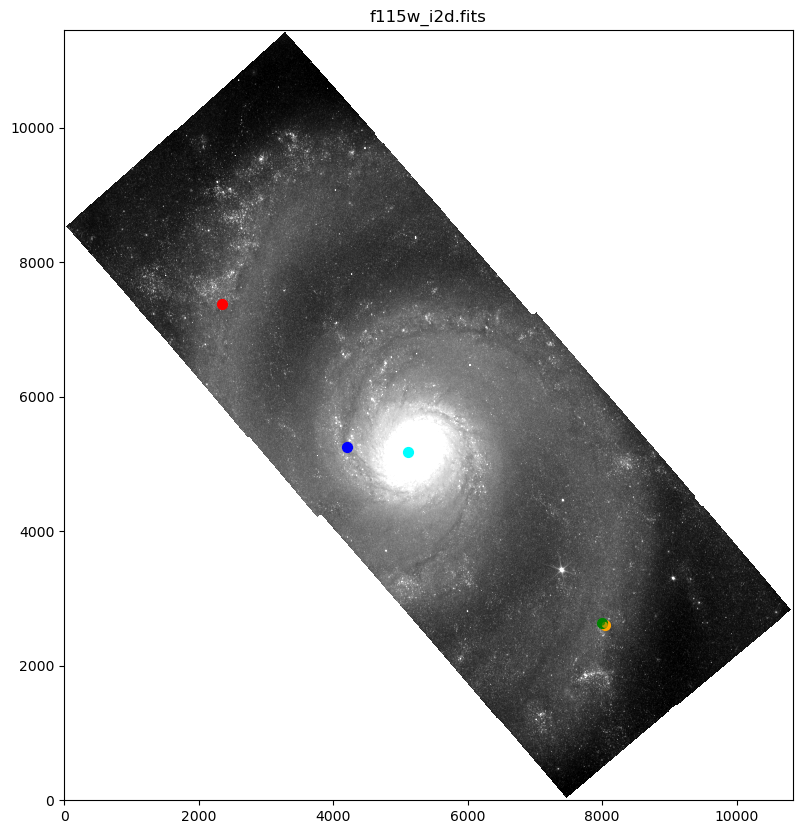

Set DATE-AVG to '2024-06-01T13:27:19.596' from MJD-AVG.
Set DATE-END to '2024-06-01T13:42:24.752' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -33.360950 from OBSGEO-[XYZ].
Set OBSGEO-H to 1709837637.033 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Total flux in aperture 3: 3.0393459856326933e-30
expected 2.972474435743118e-30, ratio : 0.9779980462225478


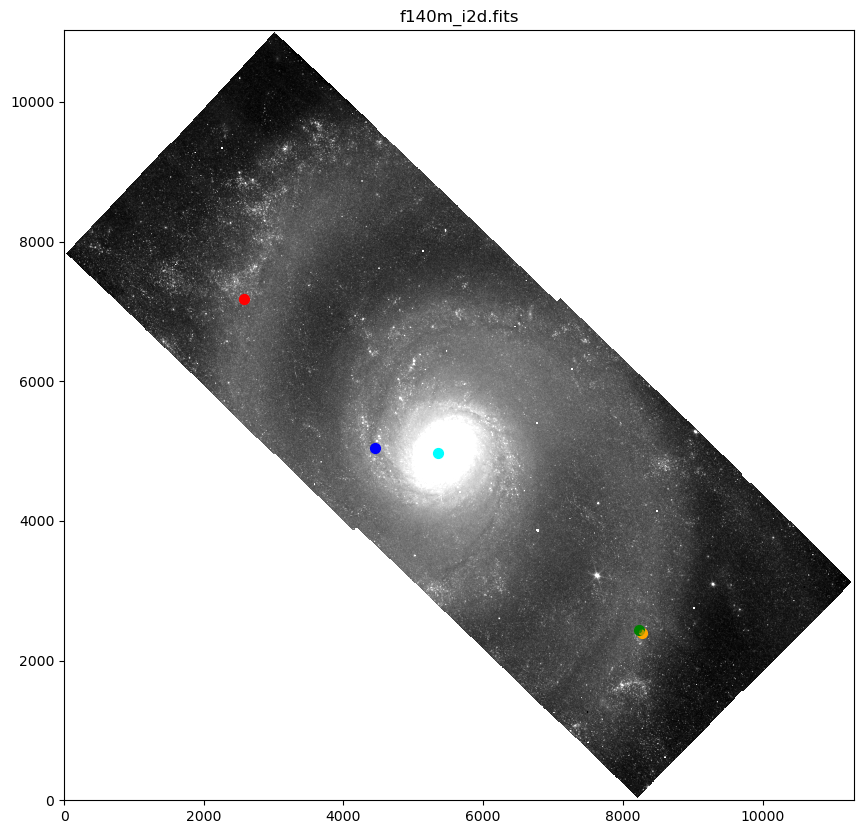

Set DATE-AVG to '2023-06-14T19:31:08.184' from MJD-AVG.
Set DATE-END to '2023-06-14T19:49:01.355' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -35.950777 from OBSGEO-[XYZ].
Set OBSGEO-H to 1721212852.647 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Total flux in aperture 3: 3.031145530097214e-30
expected 2.989469679299157e-30, ratio : 0.9862507918593006


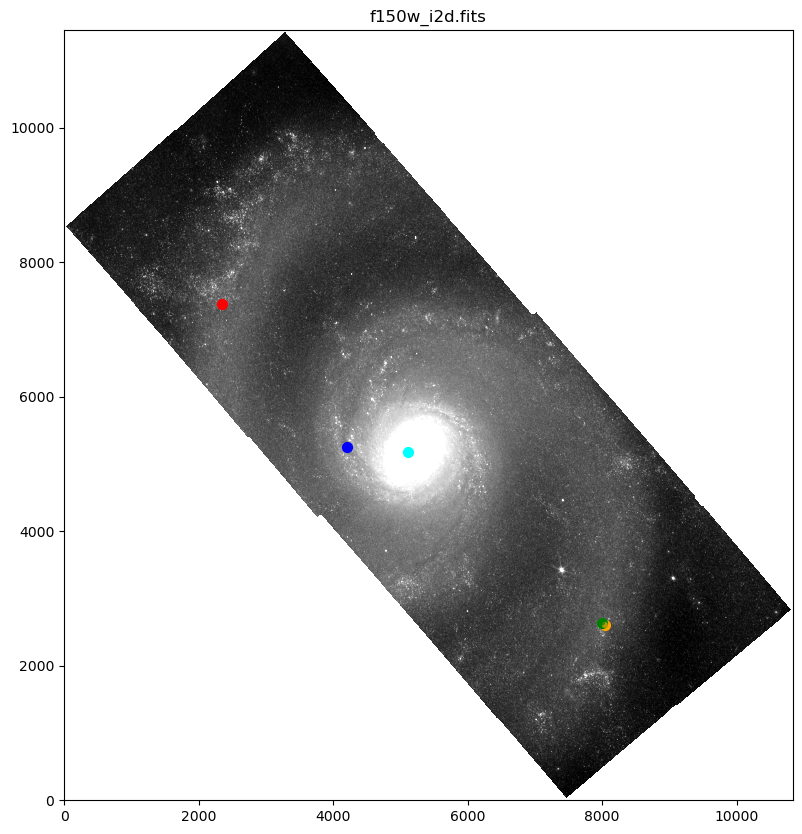

Set DATE-AVG to '2024-06-01T13:58:11.618' from MJD-AVG.
Set DATE-END to '2024-06-01T14:03:17.679' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -33.368902 from OBSGEO-[XYZ].
Set OBSGEO-H to 1709887439.726 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Total flux in aperture 3: 3.9275777907259896e-30
expected 3.94405009108192e-30, ratio : 1.004194009955659


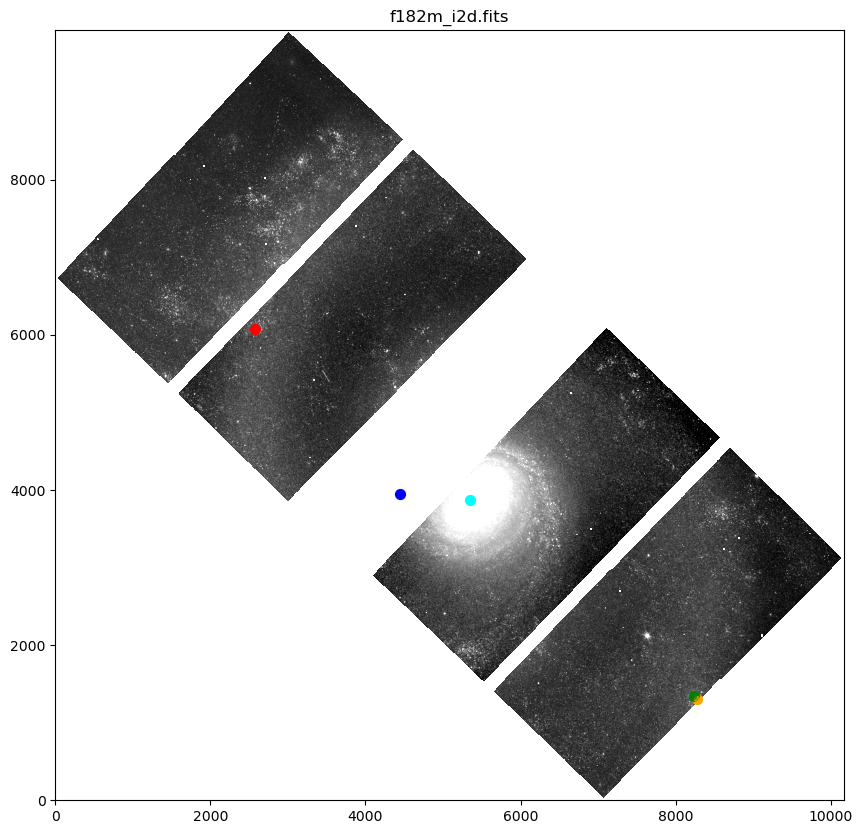

Set DATE-AVG to '2024-06-01T14:34:37.050' from MJD-AVG.
Set DATE-END to '2024-06-01T14:39:43.085' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -33.375987 from OBSGEO-[XYZ].
Set OBSGEO-H to 1709931755.781 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Total flux in aperture 3: 3.6428545569535746e-30
expected 3.0068650157017622e-30, ratio : 0.825414511804261


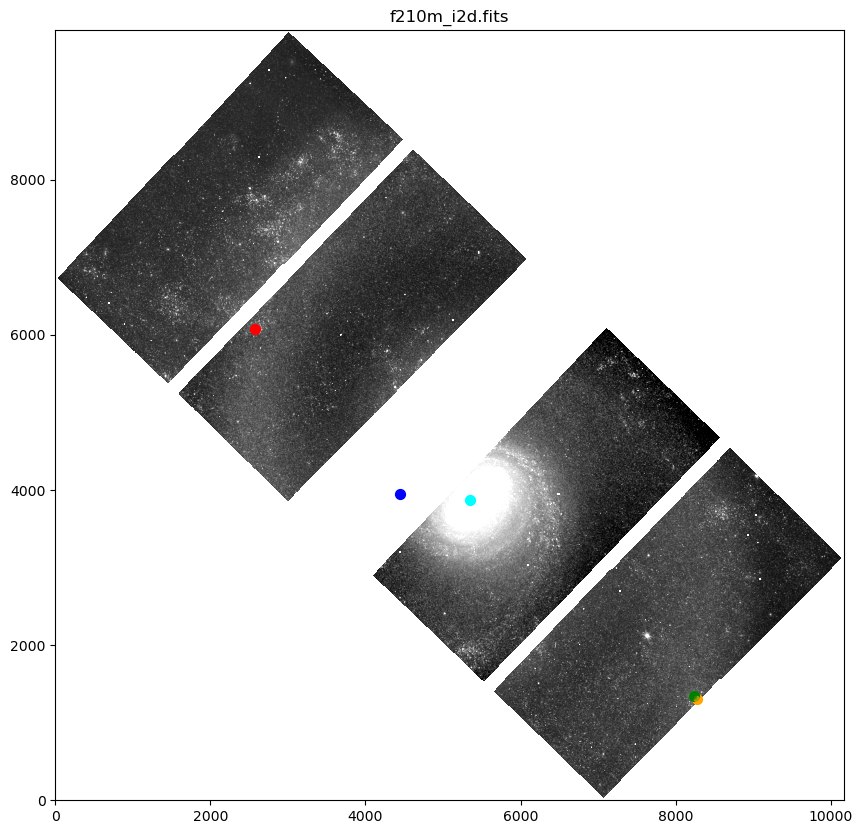

Set DATE-AVG to '2024-06-01T05:33:48.833' from MJD-AVG.
Set DATE-END to '2024-06-01T13:42:24.752' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -33.081922 from OBSGEO-[XYZ].
Set OBSGEO-H to 1708040882.602 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Total flux in aperture 3: 2.3182400932611317e-30
expected 2.5165929042532306e-30, ratio : 1.0855618068071071


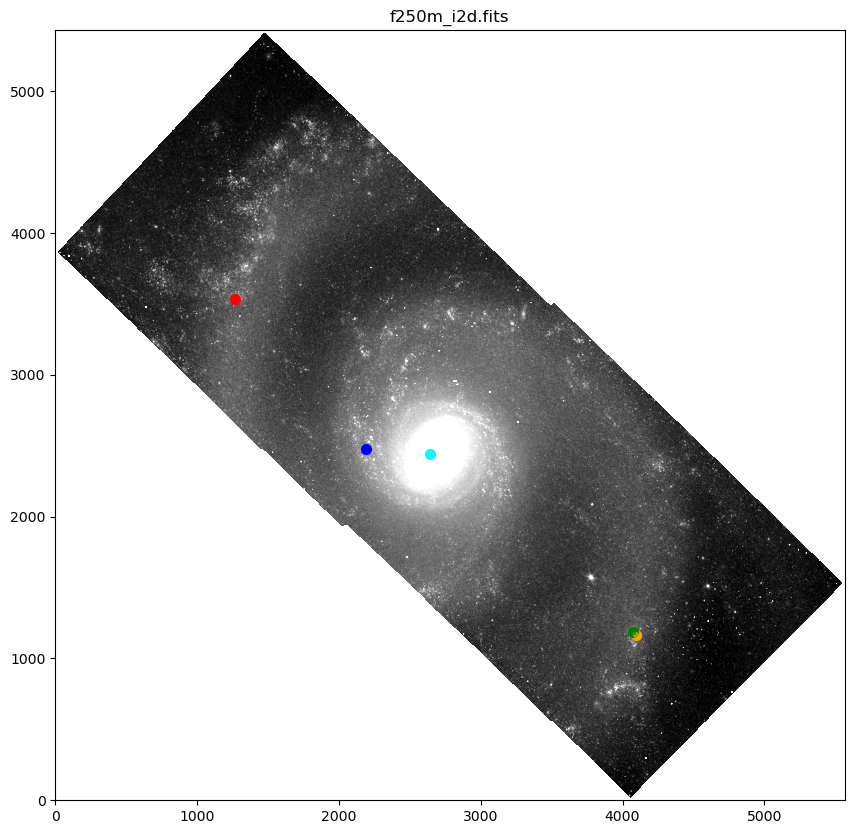

Set DATE-AVG to '2023-06-14T20:35:21.051' from MJD-AVG.
Set DATE-END to '2023-06-14T21:11:08.390' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -35.958281 from OBSGEO-[XYZ].
Set OBSGEO-H to 1721253181.761 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Total flux in aperture 3: 3.558900991184159e-30
expected 3.4778839271825275e-30, ratio : 0.977235370075672


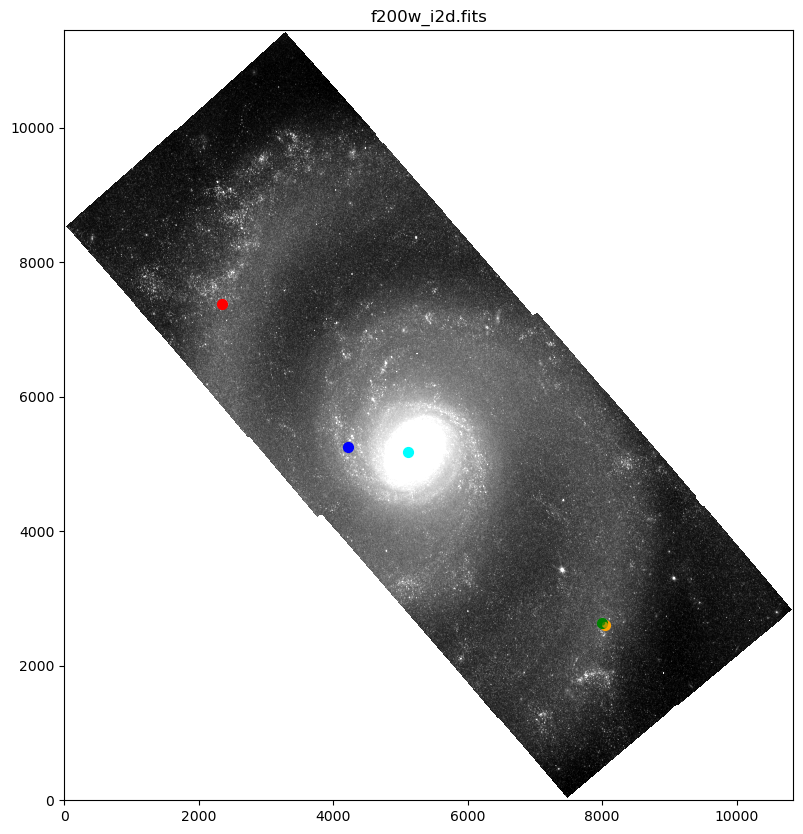

Set DATE-AVG to '2024-06-01T12:43:00.408' from MJD-AVG.
Set DATE-END to '2024-06-01T12:48:53.427' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -33.354134 from OBSGEO-[XYZ].
Set OBSGEO-H to 1709794902.230 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Total flux in aperture 3: 3.566514962562104e-30
expected 2.9373823500432453e-30, ratio : 0.8236001757674096


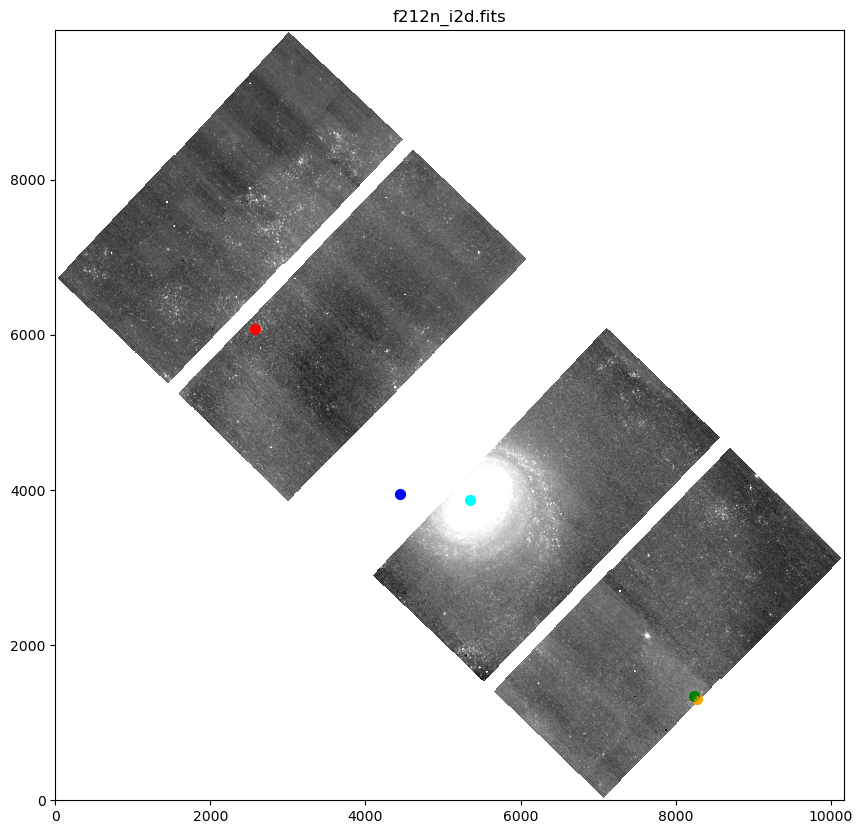

Set DATE-AVG to '2023-06-08T01:54:00.173' from MJD-AVG.
Set DATE-END to '2023-06-08T03:11:15.660' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -34.219321 from OBSGEO-[XYZ].
Set OBSGEO-H to 1710467029.601 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Total flux in aperture 3: 1.3984501679291408e-29
expected 1.1303033189384114e-29, ratio : 0.8082542695190864


In [ ]:
#TJ on big beautiful cell for photometric

#TJ this cell gets the actual photometry data from Tony's files
# to get new files run at the command line:
#rclone copy m51_g_drive:/Data/GO3435/MIRI/Tony_reduction/v0p2/ /d/ret1/Taylor/jupyter_notebooks/Research/Data_files --include "*.fits"



'''
Draine info on regions, radius = 0.750 arcseconds
202.5062429  47.2143358  0.750  ARM1_HII
202.4335225  47.1729608  0.750  ARM2_HII1
202.4340450  47.1732517  0.750  ARM2_HII2 #TJ my region SW2 region
202.4823742  47.1958589  0.750  ARM3_HII
'''
# Define aperture (RA, Dec in degrees, radius in arcseconds)
arm1h_loc = [202.5062429, 47.2143358]
arm2h1_loc = [202.4335225, 47.1729608]
arm2h2_loc = [202.4340450, 47.1732517]
arm3h_loc = [202.4823742, 47.1958589]
#TJ m51 agn is at RA 13h 29m 53s | Dec +47° 11′
agn_loc = [(((13 + ((29/60) + (53/3600)))/24)*(360)), (47 + (11/60) + (43/3600))]
print(agn_loc[0], agn_loc[1],0)
filter_name_array = [f.split("/")[-1] for f in filter_files]
obs_flux_array = []
for i, file in enumerate(image_files):
    hdul = fits.open(file)
    data = hdul['SCI'].data*1e-20  # flux in MJy/sr or μJy/arcsec²
    header = hdul['SCI'].header
    exp_time = header['XPOSURE']
    pix_area = header["PIXAR_SR"]
    wcs = WCS(header)
    radius = 0.75 * u.arcsec
    radius_pixels = (radius).to_value(u.deg) / abs(header['CDELT2'])
    
    # Convert RA/Dec to pixel coordinates
    agn_x, agn_y = wcs.all_world2pix(agn_loc[0], agn_loc[1],0)
    x1, y1 = wcs.all_world2pix(arm1h_loc[0], arm1h_loc[1], 0)
    x2, y2 = wcs.all_world2pix(arm2h1_loc[0], arm2h1_loc[1], 0)
    x3, y3 = wcs.all_world2pix(arm2h2_loc[0], arm2h2_loc[1], 0)
    x4, y4 = wcs.all_world2pix(arm3h_loc[0], arm3h_loc[1], 0)
    aperture1 = CircularAperture((x1, y1), r=radius.to_value(u.deg) / header['CDELT2'])
    aperture2 = CircularAperture((x2, y2), r=radius.to_value(u.deg) / header['CDELT2'])
    aperture3 = CircularAperture((x3, y3), r=radius.to_value(u.deg) / header['CDELT2'])
    aperture4 = CircularAperture((x4, y4), r=radius.to_value(u.deg) / header['CDELT2'])
    agn_aperture = CircularAperture((agn_x, agn_y), r = (radius.to_value(u.deg) / header['CDELT2'])) 
    
    # Perform aperture photometry
    phot_result1 = aperture_photometry(data, aperture1)
    phot_result2 = aperture_photometry(data, aperture2)
    phot_result3 = aperture_photometry(data, aperture3)
    phot_result4 = aperture_photometry(data, aperture4)
    agn_phot = aperture_photometry(data,agn_aperture)
    total_flux1 = phot_result1['aperture_sum'][0]*pix_area  # in image units
    total_flux2 = phot_result2['aperture_sum'][0]*pix_area  # in image units
    total_flux3 = phot_result3['aperture_sum'][0]*pix_area  # in image units
    total_flux4 = phot_result4['aperture_sum'][0]*pix_area  # in image units
    
    total_agn_flux = agn_phot['aperture_sum'][0]*pix_area
    
    # Apply unit conversion if needed (e.g., MJy/sr → μJy)

    #print(f"Total flux in aperture 1: {total_flux1} W/m^2/Hz")
    #print(f"Total flux in aperture 2: {total_flux2} W/m^2/Hz")
    print(f"Total flux in aperture 3: {total_flux3}")
    print(f"expected {expected_flux_array[i]}, ratio : {expected_flux_array[i]/total_flux3}")
    
    #print(f"Total flux in aperture 4: {total_flux4} W/m^2/Hz")
    #print(f"total flux from AGN : {total_agn_flux} W/m^2/Hz")

    obs_flux_array.append(total_flux3)
    def show_image(file):
        plt.figure(figsize=(12, 10))  # Larger figure
    
        data = fits.getdata(file)
        norm = simple_norm(data, stretch='asinh', percent=96.9)
        plt.imshow(data, norm=norm, cmap='gray', origin='lower')
        # Mark aperture center with a red dot
        plt.scatter(x1, y1, color='red', s=50, label='Aperture Center')  # s=size
        plt.scatter(x2, y2, color='orange', s=50, label='Aperture Center')  # s=size
        plt.scatter(x3, y3, color='green', s=50, label='Aperture Center')  # s=size
        plt.scatter(x4, y4, color='blue', s=50, label='Aperture Center')  # s=size
        plt.scatter(agn_x, agn_y, color='cyan', s=50, label='AGN')  # s=size
        
        # (Optional) Overlay the aperture circle
        aperture1 = CircularAperture((x1, y1), r=radius_pixels)
        aperture2 = CircularAperture((x2, y2), r=radius_pixels)
        aperture3 = CircularAperture((x3, y3), r=radius_pixels)
        aperture4 = CircularAperture((x4, y4), r=radius_pixels)
        agn_aperture = CircularAperture((agn_x, agn_y), r = radius_pixels)
        aperture1.plot(color='red', lw=2, alpha=0.7, label=f'{radius}" Aperture')
        aperture2.plot(color='orange', lw=2, alpha=0.7, label=f'{radius}" Aperture')
        aperture3.plot(color='green', lw=2, alpha=0.7, label=f'{radius}" Aperture')
        aperture4.plot(color='blue', lw=2, alpha=0.7, label=f'{radius}" Aperture')
        agn_aperture.plot(color = 'cyan', lw=2, alpha=0.7, label = 'AGN')
        plt.title(f'{file.split("lv3_")[-1]}')
        plt.show()
    show_image(file)
obs_flux_array = np.array(obs_flux_array)
expected_flux_array = np.array(expected_flux_array)

In [ ]:
expected_array = np.array([i for i in expected_flux_array])

observed_array = np.array(obs_flux_array)

# Extract the numerical part from filter names and get sorting indices
def get_filter_number(name):
    """
    Extract numbers between any two letters in a filter name.
    Examples:
        'F1130W' → 1130
        'F200W'  → 200
        'F560M'  → 560
        'NIRCam-F444W' → 444
    """
    match = re.search(r'[A-Za-z](\d+)[A-Za-z]', name)  # Numbers between ANY letters
    return int(match.group(1)) if match else 0

# Create array of numerical values for sorting
filter_numbers = np.array([get_filter_number(name) for name in filter_name_array])

# Get the sorting indices
sort_indices = np.argsort(filter_numbers)

# Apply sorting to all arrays
sorted_filter_names = np.array(filter_name_array)[sort_indices]
sorted_expected = np.array(expected_array)[sort_indices]

sorted_observed = np.array(observed_array)[sort_indices]
# Set a professional style at the beginning
plt.style.use('seaborn-v0_8-paper')  # Or try 'seaborn-whitegrid', 'ggplot'

# Use a larger font size for readability
plt.rcParams.update({'font.size': 12, 'axes.titlesize': 14, 'axes.labelsize': 12})
# Now plot with sorted data
plt.figure(figsize=(10, 6))
plt.scatter([x.split('.')[0] for x in sorted_filter_names], sorted_expected/sorted_expected, label='Spectrum-derived', s=100, marker='o', color='blue')

plt.scatter([x.split('.')[0] for x in sorted_filter_names], sorted_observed/sorted_expected, label='Image-extracted', s=100, marker='x', color='red')

plt.xticks(rotation=45, ha='right')
plt.tick_params(axis='y', which='both', labelsize=10)
plt.legend()
plt.xlabel('Filter Names')
plt.ylabel('Filter Pass Through (MJy)')
plt.title("FLux transmitted through filter compared to spectrum-derived expectations \nNormalized to Spectrum-derived values")
plt.tight_layout()
plt.show()

# Set a professional style at the beginning
plt.style.use('seaborn-v0_8-paper')  # Or try 'seaborn-whitegrid', 'ggplot'

# Use a larger font size for readability
plt.rcParams.update({'font.size': 12, 'axes.titlesize': 14, 'axes.labelsize': 12})
plt.figure(figsize=(10, 6))
plt.xticks(rotation=45, ha='right')

plt.scatter([x.split('.')[0] for x in sorted_filter_names], sorted_expected, label='Spectrum-derived', s=100, marker='o', color='blue')

plt.scatter([x.split('.')[0] for x in sorted_filter_names], sorted_observed, label='Image-extracted', s=100, marker='x', color='red')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.yscale('log')
plt.xlabel('Filter Names')
plt.ylabel('Filter Pass Through (MJy)')
plt.title('FLux transmitted through filter compared to spectrum-derived expectations')
plt.show()


In [ ]:
file = IFU_filepath
hdul = fits.open(file)
data = hdul['SCI'].data  # flux in MJy/sr or μJy/arcsec²
header = hdul['SCI'].header
header

In [ ]:
hdul = fits.open(image_files[0])
header = hdul['SCI'].header
header

In [ ]:
#TJ Now comparing model to model filter fluxes
def good(Fnu_array, wl_array, transmission_array, trans_wl_array):
    """
    Returns expected flux in mJy through a filter.
    All wavelength inputs are in meters. Fnu_array must be in mJy.
    """
    Fnu_array = np.array(Fnu_array)
    wl_array = np.array(wl_array)
    transmission_array = np.array(transmission_array)
    trans_wl_array = np.array(trans_wl_array)
    mask = [((wl_array >= trans_wl_array[0]) & (wl_array <= trans_wl_array[-1]))][0]
    
    # Convert wavelength to frequency, reverse so freq increases left to right
    spec_freq_array = c / wl_array[::-1]
    Fnu_array = Fnu_array[::-1]

    trans_freq_array = c / trans_wl_array[::-1]
    transmission_array = transmission_array[::-1]
    rel_spec_freq = spec_freq_array[((spec_freq_array > trans_freq_array[0]) & (spec_freq_array < trans_freq_array[-1]))]
    rel_Fnu = Fnu_array[((spec_freq_array > trans_freq_array[0]) & (spec_freq_array < trans_freq_array[-1]))]
    # Interpolate Fnu onto the transmission frequency grid
    interp_Fnu = np.interp(trans_freq_array, spec_freq_array, Fnu_array)
    weight = transmission_array / trans_freq_array
    numerator = np.trapz(interp_Fnu * weight, trans_freq_array)
    denominator = np.trapz(weight, trans_freq_array)

    T_interp = np.interp(rel_spec_freq, trans_freq_array, transmission_array)
    test_weight = T_interp / rel_spec_freq
    test_num = np.trapz(rel_Fnu*test_weight, rel_spec_freq)
    test_den = np.trapz(test_weight, rel_spec_freq)
    
    ab_mean_flux = numerator / denominator
    test_results = test_num/test_den
    # Numerator: Fν * Transmission integrated over frequency
    
    return ab_mean_flux, test_results

def test2(Fnu_array, wl_array, transmission_array, trans_wl_array):
    """
    Returns expected flux in mJy through a filter.
    All wavelength inputs are in meters. Fnu_array must be in mJy.
    """
    Fnu_array = np.array(Fnu_array)
    wl_array = np.array(wl_array)
    transmission_array = np.array(transmission_array)
    trans_wl_array = np.array(trans_wl_array)
    # Convert wavelength to frequency, reverse so freq increases left to right
    spec_freq_array = c / wl_array[::-1]
    Fnu_array = Fnu_array[::-1]

    trans_freq_array = c / trans_wl_array[::-1]
    transmission_array = transmission_array[::-1]

    # cross_match into observed frequencies
    closest_indices = np.argmin(np.abs(trans_freq_array[:, None] - spec_freq_array), axis=0)
    closest_T_array = transmission_array[closest_indices]
    
    interp_Fnu = np.interp(trans_freq_array, spec_freq_array, Fnu_array)
    weight = transmission_array / trans_freq_array
    numerator = np.trapz(interp_Fnu * weight, trans_freq_array)
    denominator = np.trapz(weight, trans_freq_array)
    ab_mean_flux = numerator / denominator
    # Numerator: Fν * Transmission integrated over frequency
    
    return ab_mean_flux

def predict_filter_band_pass(flux_array, spec_wl_array, transmission_array, transmission_wl_array):
    '''get expected flux through filter in units of whatever the flux_array is. Make sure to convert to mks units
    -------------
    Parameters
    -------------
    flux_array : type = array - array of flux values
    spec_wl_array : type = array - array of wavelength values for the corresponding flux_array values
    transmission_array : type = array - array of unitless transmission coefficient
    transmission_wl_array : type = array - array of wavelength values for the corresponding transmission values


    
    Returns
    -------------
    total_flux : type = float - in units of flux_array
    '''   

    
    
    flux_array = np.array(flux_array)
    spec_wl_array = np.array(spec_wl_array)
    transmission_array = np.array(transmission_array)
    transmission_wl_array = np.array(transmission_wl_array)
    #Try normalizing to max Transmission:
    max_t = np.max(transmission_array)
    
    
    first_wl = transmission_wl_array[0]
    last_wl = transmission_wl_array[-1]
    rel_wl_array = spec_wl_array[((spec_wl_array >= first_wl) & (spec_wl_array <= last_wl))]
    rel_flux_array = flux_array[((spec_wl_array >= first_wl) & (spec_wl_array <= last_wl))]
    
    closest_indices = np.argmin(np.abs(transmission_wl_array[:, None] - rel_wl_array), axis=0)
    closest_T_array = transmission_array[closest_indices]
    T_interp = np.interp(rel_wl_array, transmission_wl_array, transmission_array)
    
    interp_F_T = rel_flux_array * T_interp
    nk_F_T = rel_flux_array * closest_T_array
    
    interp_numerator = np.trapz(interp_F_T, rel_wl_array)
    nk_numerator = np.trapz(nk_F_T, rel_wl_array)
    
    denominator = np.trapz(transmission_array, transmission_wl_array)
    
    interp_flux = ((interp_numerator/denominator))
    nk_flux = ((nk_numerator/denominator))
    
    
    return interp_flux, nk_flux

def get_error(observed, expected):
    return ((observed-expected)/expected)*100

filter_flux_file_path =  '/d/vel2/ddale/phangs/synthetic/templates/models-block-0.fits'
filter_flux_file = fits.open(filter_flux_file_path)
filter_flux_tbl = Table.read(filter_flux_file[1])
table_data = []

spectral_file_path = '/d/vel2/ddale/phangs/synthetic/templates/00_best_model.fits'
spectral_file = fits.open(spectral_file_path)
spec_tbl = Table.read(spectral_file_path, hdu=1)
wl_array = spec_tbl['wavelength']*1e-9
Fnu_array = spec_tbl['Fnu']
keep = [23, 19, 12, 11, 10]

best = []
test = []
for filter_data in [filter_data_array[i] for i in keep]:
    trans_wl_array = filter_data[0]
    transmission_array = filter_data[1]
    results = good(Fnu_array, wl_array, transmission_array, trans_wl_array)
    best.append(results[0])
    test.append(results[1])



for i in range(5):
    filter_name = [filter_name_array[j] for j in keep][i]
    reported_value = filter_flux_tbl[0][filter_flux_tbl.colnames[i+1]]
    best_error = get_error(best[i], reported_value)
    test_error = get_error(test[i], reported_value)
    
    table_data.append([
        filter_name,
        f"{reported_value:.0f}",
        f"{best[i]:.2f}",
        f"{best_error:.4f}%",
        f"{test[i]:.2f}",
        f"{test_error:.4f}%"

        
    ])

# Print the table with headers
headers = [
    "Filter", 
    "Real_flux", 
    "best",
    "best_error",
    "test",
    "test error"
]
print('"test" trials are using interpolated transmission factors at intermediate wavelengths. \n"best" trials use interpolated flux values to get flux at the exact wavelength the transmission data is given for.')
print(tabulate(table_data, headers=headers, tablefmt="grid", floatfmt=".0f"))

In [ ]:
filter_flux_file_path =  '/d/vel2/ddale/phangs/synthetic/templates/models-block-0.fits'
filter_flux_file = fits.open(filter_flux_file_path)
filter_flux_tbl = Table.read(filter_flux_file[1])
filter_flux_tbl

In [ ]:
plt.plot(wl_array, Fnu_array)
plt.yscale('log')
plt.xscale('log')
plt.show()
spec_tbl

In [ ]:
plt.figure(figsize=(10, 6), dpi=300)  # Higher DPI for publication

# Plot with error bars if you have them

plt.scatter([x.split('.')[0] for x in sorted_filter_names], 
            sorted_observed/sorted_expected, 
            label='Image-extracted', 
            s=100, marker='x', color='red', linewidth=1.5)

plt.xticks(rotation=45, ha='right')
plt.tick_params(axis='y', which='both', labelsize=14)
plt.tick_params(axis='x', which='both', labelsize=12)

plt.xlabel('Filter Names', fontweight='bold')
plt.ylabel('f_nu(image-extracted)/f_nu(spectrally-derived)', fontweight='bold')

# More professional title (consider moving to caption)
plt.title("FLux transmitted through filter compared to spectrum-derived expectations \nNormalized to Spectrum-derived values", pad=20)


# Adjust y-axis limits if needed
plt.ylim(0.9*min(sorted_observed/sorted_expected), 1.1*max(sorted_observed/sorted_expected))

plt.tight_layout()
plt.axvline(x=15.5, color='gray', linestyle='--', linewidth=1, alpha=0.7)
plt.axhline(y=1, color='gray', linestyle='--', linewidth=1, alpha=0.3)
ymin, ymax = plt.ylim()
# Place text at 90% of ymax
text_y_pos = ymax * 0.95

# Add NIRCam label to the left
plt.text(15.25, text_y_pos, "← NIRCam", 
         ha='right', va='center', 
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=2),
         fontsize=10)

# Add MIRI label to the right
plt.text(15.75, text_y_pos, "MIRI →", 
         ha='left', va='center', 
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=2),
         fontsize=10)

plt.savefig('flux_comparison_normalized.png', bbox_inches='tight', transparent=False)
plt.show()





plt.figure(figsize=(10, 6), dpi=300)

# Use consistent color scheme with first plot
plt.scatter([x.split('.')[0] for x in sorted_filter_names], 
            sorted_expected, 
            label='Spectrum-derived', 
            s=100, marker='o', color='blue', edgecolor='black', linewidth=0.5)

plt.scatter([x.split('.')[0] for x in sorted_filter_names], 
            sorted_observed, 
            label='Image-extracted', 
            s=100, marker='x', color='red', linewidth=1.5)

plt.xticks(rotation=45, ha='right')
plt.tick_params(axis='y', which='both', labelsize=14)
plt.tick_params(axis='x', which='both', labelsize=12)
plt.legend(frameon=True, framealpha=1, loc='best')
plt.yscale('log')
plt.xlabel('Filter Names', fontweight='bold')
plt.ylabel('Flux density \n$(W/m^2/Hz)$', fontweight='bold')  # Verify units
plt.title("FLux transmitted through filter compared to spectrum-derived expectations", pad=20)

plt.axvline(x=15.5, color='gray', linestyle='--', linewidth=1, alpha=0.7)
ymin, ymax = plt.ylim()
# Place text at 90% of ymax
text_y_pos = ymax * 0.7

# Add NIRCam label to the left
plt.text(15.25, text_y_pos, "← NIRCam", 
         ha='right', va='center', 
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=2),
         fontsize=10)

# Add MIRI label to the right
plt.text(15.75, text_y_pos, "MIRI →", 
         ha='left', va='center', 
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=2),
         fontsize=10)
plt.tight_layout()
plt.savefig('flux_comparison.png', bbox_inches='tight', transparent=False)
plt.show()

In [ ]:
np.std(sorted_observed/sorted_expected)

In [ ]:
np.var(sorted_observed/sorted_expected)

In [ ]:
0.0152699**0.5